# Wake word detection!
This wake word detection is done for our ongoing project! A wake word is a word for which your system responds to- similar to Alexa, OK google and hey siri.
Here, we used a custom wake word-"Help Me" and trained our model with it.

This works by training our model to recognize which one is the trigger word, and which one is background noise/ negative word.
For the negative words, I used the Mozilla common voice dataset available in kaggle and other websites.
For the positive words, I recorded myself saying "help me!" for about 100 times

In [2]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

First, let us set a directory where our generated audio example will be stored

In [82]:
directory_n='.//Wake-word-detection//gendata'

Now, let us load the data

In [83]:
activates,negatives,background=load_raw_audio()

In [84]:
len(background[8])

10000

The number 10000 means that the audio file is 10 second long

In [9]:
from pydub.playback import play

Now, since we have a small dataset to train with, we can use *Data Augmentation* to increase our datasize. We do this by randomly increasing/decreasing the pitch and playback speed.

In [12]:
new_sample_rate = int(activates[0].frame_rate * ( (np.random.randint(85,115)/100)))

# keep the same samples but tell the computer they ought to be played at the 
# new, higher sample rate. This file sounds like a chipmunk but has a weird sample rate.
hipitch_sound = activates[0]._spawn(activates[0].raw_data, overrides={'frame_rate': new_sample_rate})

# now we just convert it to a common sample rate (44.1k - standard audio CD) to 
# make sure it works in regular audio players. Other than potentially losing audio quality (if
# you set it too low - 44.1k is plenty) this should now noticeable change how the audio sounds.
hipitch_sound = hipitch_sound.set_frame_rate(44100)
play(hipitch_sound)


(Tweak the above parameters in the first line accordingly)

# Now, We need a few functions
1. To get a random timesegment, on where to insert the positive/negative clip
2. To check whether the inserting timesegment overlaps with the previous segments
3. To actually overlay the clip above the 10 second background clip

In [16]:
def get_random_time_segment(segment_ms):
    #Returns a random timesegment of length 'segment_ms'
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [17]:
def is_overlapping(segment_time, previous_segments):

    segment_start, segment_end = segment_time
    
    overlap = False
    
   
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
            

    return overlap

In [20]:

def insert_audio_clip(background, audio_clip, previous_segments):
   
    segment_ms = len(audio_clip)
    max_tries=200
    segment_time = get_random_time_segment(segment_ms)
    tries=0
    while is_overlapping(segment_time, previous_segments) and tries<=max_tries:
        tries+=1
        segment_time = get_random_time_segment(segment_ms)
    if(tries>=max_tries):
        return background,segment_time
    previous_segments.append(segment_time)

    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

Let us test if the code works-

In [22]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(background[0], activates[0], [])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Segment Time:  (2915, 4839)


The below code then produces the corresponding output to the audio file- Basically encodes '1' where the trigger word is found

In [23]:
Ty=1375 #This need to be set according to the  dimensions of the output of your model
def insert_ones(y, segment_end_ms):
    
    
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    
    return y

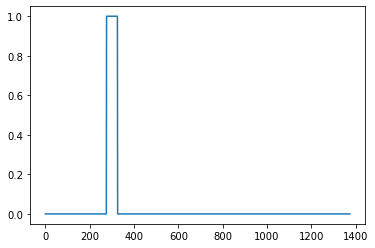

In [24]:

arr1 = insert_ones(np.zeros((1, Ty)), 2000)

plt.plot(arr1[0,:])

In [27]:
np.random.seed(18)

# Now, a function combines all the above functions-
1. Randomly select the trigger words and negative words from the array
2. Randomly overlay them across the background clip
3. Create the corresponding 'Y' or output for it

In [56]:

def create_training_example(background, activates, negatives,count=0):

    
    # Make background quieter
    background = background - 20
    y = np.zeros((1, Ty))
    previous_segments = []
    number_of_activates = np.random.randint(0, 3)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    for random_activate in random_activates:
        new_sample_rate = int(random_activate.frame_rate * ( (np.random.randint(85,115)/100)))

        
        new_pitch = random_activate._spawn(random_activate.raw_data, overrides={'frame_rate': new_sample_rate})

        new_pitch = new_pitch.set_frame_rate(44100)
        background, segment_time = insert_audio_clip(background, new_pitch, previous_segments)
        segment_start, segment_end = segment_time
        y = insert_ones(y, segment_end_ms=segment_end)

    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        
        if(len(random_negative)>9000):
            continue
        
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
#         previous_segments.append(segment_time)

#         print('added -ves')

    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    f_name="gendata/train"+ ".wav"
#     print('exporting')
    file_handle = background.export(f_name, format="wav")
    print("File (train.wav) was saved in your directory.")
    
    x = graph_spectrogram(f_name)
    
    return x, y

In [32]:
len(os.listdir(directory_n))

1

# This function then creates a dataset of specified size

In [37]:
def getsamples(background, activates, negatives):
    Xs=[]
    Ys=[]
    for i in range(10):
        bg_index=np.random.randint(0,9)
#         print('going for '+str(i))
        x,y=create_training_example(background[bg_index], activates, negatives,i)
        print('finished'+str(i))
        Xt=x.reshape( 1,5511,101)
        Yt=y.reshape(1,Ty,1)
        if(i==0):
            Xs=Xt
            Ys=Yt
        else:
            Xs=np.append(Xs,Xt,axis=0)
            Ys=np.append(Ys,Yt,axis=0)
    return Xs,Ys

    

In [38]:
x=[]
y=[]

File (train.wav) was saved in your directory.
finished0
File (train.wav) was saved in your directory.


D:\Users\f1\Anaconda3\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:7581: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


finished1
File (train.wav) was saved in your directory.
finished2
File (train.wav) was saved in your directory.
finished3
File (train.wav) was saved in your directory.
finished4
File (train.wav) was saved in your directory.
finished5
File (train.wav) was saved in your directory.
finished6
File (train.wav) was saved in your directory.
finished7
File (train.wav) was saved in your directory.
finished8
File (train.wav) was saved in your directory.
finished9


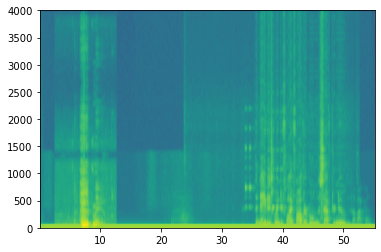

In [85]:
xm, ym = getsamples(background, activates, negatives)

In [40]:
if(len(x)==0):
    x=xm
    y=ym
else:
    x=np.append(x,xm,axis=0)
    y=np.append(y,ym,axis=0)

In [41]:
x.shape

(10, 5511, 101)

In [42]:
y.shape

(10, 1375, 1)

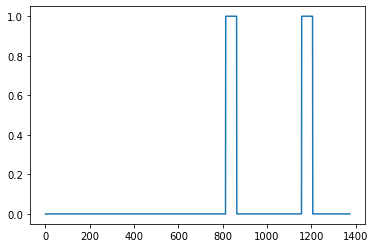

In [43]:
plt.plot(y[2])

# Now, Let us create our Model.

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input



In [45]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [46]:
from keras.optimizers import SGD


Using TensorFlow backend.


In [47]:

def model(input_shape):
   
    
    X_input = Input(shape = input_shape)
    
    
    X = Conv1D(32, kernel_size=15, strides=4)(X_input)  

    X = BatchNormalization()(X)                                 
    X = Activation('relu')(X)                                
    X = Dropout(0.3)(X)                                 

    X = GRU(units = 256, return_sequences = True)(X)
    X = Dropout(0.3)(X)                                
    X = BatchNormalization()(X)  
#     # Batch normalization
#     X = GRU(units = 128, return_sequences = True)(X) 
#     X = Dropout(0.3)(X)                                
#     X = BatchNormalization()(X)      
    
#     X = GRU(units = 64, return_sequences = True)(X)   
#     X = Dropout(0.4)(X)                                 
#     X = BatchNormalization()(X)                                  
#     X = Dropout(0.4)(X)                                  
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [48]:
model = model(input_shape = (Tx, n_freq))
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5511, 101)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1375, 32)          48512     
_________________________________________________________________
batch_normalization (BatchNo (None, 1375, 32)          128       
_________________________________________________________________
activation (Activation)      (None, 1375, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1375, 32)          0         
_________________________________________________________________
gru (GRU)                    (None, 1375, 256)         222720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1375, 256)        

In [50]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

If youre using a bigger dataset, try saving your numpy arrays so you can use it later.

In [52]:
# np.save('xdat.npy',x)
# np.save('ydat.npy',y)

In [54]:
model.fit(x, y, batch_size=1,validation_split=0.15, epochs=2)

Epoch 1/2
8/8 [==============================] - 6s 807ms/step - loss: 0.7233 - accuracy: 0.5080 - val_loss: 0.6701 - val_accuracy: 0.9345
Epoch 2/2
8/8 [==============================] - 6s 739ms/step - loss: 0.7141 - accuracy: 0.6175 - val_loss: 0.6643 - val_accuracy: 0.9371


# Now that our model has been trained, we can now implement it in our android device too! This can be done by converting our model into a tflite file.

**Note: At the time of writing this, there seems to be a compatibility issue when exporting the a model trained in Tensorflow 2.3 and importing it in tensorflow lite. So, I used the tf-nightly(2.5.0-dev20201204) and trained in google colab instead,on a slightly bigger dataset.**

In [57]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()

# Save the model.
with open('model2.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\f1\AppData\Local\Temp\tmpak36ydg5\assets


INFO:tensorflow:Assets written to: C:\Users\f1\AppData\Local\Temp\tmpak36ydg5\assets


In [44]:
model.save('saved_models/my_model-acc-test')

INFO:tensorflow:Assets written to: saved_models/my_model-acc-test\assets


INFO:tensorflow:Assets written to: saved_models/my_model-acc-test\assets


In [9]:
from keras.models import load_model 

Using TensorFlow backend.


In [64]:
import tensorflow as tf

The below Mentioned tf-file was trained on a slightly different set of parameters in google colab.
- dataset_size=650(due to memory limitations)
- batch_size=16
- validation_split=0.20
- epochs=10
- training-accuracy=92
- tf-version=2.5.0-dev20201204

(Note that the dataset used is entirely based on my voice, so I recommended using a fresh dataset if you're creating a model similar to this)

In [65]:
model=tf.keras.models.load_model('./saved_models/four-nightly')

# Now, the code for listing to trigger words

In [57]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
# To generate wav file from np array.
from scipy.io.wavfile import write
%matplotlib inline

In [58]:
np.set_printoptions(threshold=1000)


In [66]:

def detect_triggerword_spectrum(x):
    """
    Function to predict the location of the trigger word.
    
    Argument:
    x -- spectrum of shape (freqs, Tx)
    i.e. (Number of frequencies, The number time steps)

    Returns:
    predictions -- flattened numpy array to shape (number of output time steps)
    """
    # the spectogram outputs  and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    return predictions.reshape(-1)

def has_new_triggerword(predictions, chunk_duration, feed_duration, threshold=0.5):
    """
    Function to detect new trigger word in the latest chunk of input audio.
    It is looking for the rising edge of the predictions data belongs to the
    last/latest chunk.
    
    Argument:
    predictions -- predicted labels from model
    chunk_duration -- time in second of a chunk
    feed_duration -- time in second of the input to model
    threshold -- threshold for probability above a certain to be considered positive

    Returns:
    True if new trigger word detected in the latest chunk
    """
    predictions = predictions > threshold
    chunk_predictions_samples = int(len(predictions) * chunk_duration / feed_duration)
    chunk_predictions = predictions[-chunk_predictions_samples:]
    level = chunk_predictions[0]
    for pred in chunk_predictions:
        if pred > level:
            return True
        else:
            level = pred
    return False
    
    

# Record audio stream from mic

In [67]:
chunk_duration = 0.5 # Each read length in seconds from mic.
fs = 44100 # sampling rate for mic
chunk_samples = int(fs * chunk_duration) # Each read length in number of samples.

# Each model input data duration in seconds, need to be an integer numbers of chunk_duration
feed_duration = 10
feed_samples = int(fs * feed_duration)

assert feed_duration/chunk_duration == int(feed_duration/chunk_duration)

In [68]:
def get_spectrogram(data):
    """
    Function to compute a spectrogram.
    
    Argument:
    predictions -- one channel / dual channel audio data as numpy array

    Returns:
    pxx -- spectrogram, 2-D array, columns are the periodograms of successive segments.
    """
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, _, _ = mlab.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, _, _ = mlab.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

In [69]:
def plt_spectrogram(data):
    """
    Function to compute and plot a spectrogram.
    
    Argument:
    predictions -- one channel / dual channel audio data as numpy array

    Returns:
    pxx -- spectrogram, 2-D array, columns are the periodograms of successive segments.
    """
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, _, _, _ = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, _, _, _ = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

### Audio stream

In [70]:

def get_audio_input_stream(callback):
    stream = pyaudio.PyAudio().open(
        format=pyaudio.paInt16,
        channels=1,
        rate=fs,
        input=True,
        frames_per_buffer=chunk_samples,
        input_device_index=1,
        stream_callback=callback)
    return stream

In [71]:
import pyaudio
from queue import Queue
from threading import Thread
import sys
import time


# Queue to communiate between the audio callback and main thread
q = Queue()

run = True

silence_threshold = 100

# Run the demo for a timeout seconds
timeout = time.time() + 0.5*60  # 0.5 minutes from now

# Data buffer for the input wavform
data = np.zeros(feed_samples, dtype='int16')

def callback(in_data, frame_count, time_info, status):
    global run, timeout, data, silence_threshold    
    if time.time() > timeout:
        run = False        
    data0 = np.frombuffer(in_data, dtype='int16')
    if np.abs(data0).mean() < silence_threshold:
        sys.stdout.write('-')
        return (in_data, pyaudio.paContinue)
    else:
        sys.stdout.write('.')
    data = np.append(data,data0)    
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        # Process data async by sending a queue.
        q.put(data)
    return (in_data, pyaudio.paContinue)

stream = get_audio_input_stream(callback)
stream.start_stream()


try:
    while run:
        data = q.get()
        spectrum = get_spectrogram(data)
        preds = detect_triggerword_spectrum(spectrum)
        new_trigger = has_new_triggerword(preds, chunk_duration, feed_duration)
        if new_trigger:
            sys.stdout.write('1')
except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False
        
stream.stop_stream()
stream.close()

-.-...1---..1.--.1.---..--.1.---..-...1.---.---.1.----..1---..1.1.1.

In [47]:
stream.stop_stream()
stream.close()

In [261]:
n=[]

In [14]:
# Convert the model from the saved model
converter = tf.lite.TFLiteConverter.from_saved_model('./saved_models/four-nightly') # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Save the model.
with open('./thefinal-4th-nightly.tflite', 'wb') as f:
  f.write(tflite_model)

Let us test if the model works

In [72]:
import tensorflow as tf

import numpy as np
# converter = tf.lite.TFLiteConverter.from_saved_model('./saved_models/latest7')
# tflite_model = converter.convert()
# open("final_mod.tflite", "wb").write(tflite_model)

In [73]:
interpreter = tf.lite.Interpreter(model_path="4nightly.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [74]:
output_details[0]['shape']

array([   1, 1375,    1])

In [75]:
x[0].shape

(5511, 101)

In [76]:
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

In [77]:
interpreter.set_tensor(input_details[0]['index'], input_data)

In [78]:
interpreter.invoke()


In [79]:
output_data = interpreter.get_tensor(output_details[0]['index'])


In [80]:
print(output_data)


[[[0.4537226 ]
  [0.45437485]
  [0.45478043]
  ...
  [0.45531306]
  [0.4553123 ]
  [0.45531297]]]
